<a href="https://colab.research.google.com/github/dougyd92/ResNet/blob/main/BestModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Best ResNet Model

Run this if you just want to train the best model found by our hyperparameter sweep.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
# Based on example code from: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, strides=[1,2,2,2], num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=strides[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=strides[1])
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=strides[2])
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=strides[3])
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        if num_blocks > 0:
            strides = [stride] + [1]*(num_blocks-1)
            layers = []
            for stride in strides:
                layers.append(block(self.in_planes, planes, stride))
                self.in_planes = planes * block.expansion
            return nn.Sequential(*layers)
        else:
            # While we try different number of blocks per layer,
            # allow for a value of 0 blocks to mean use a single
            # conv layer instead of a residual block
            layer =  nn.Sequential(nn.Conv2d(self.in_planes, planes, kernel_size=1,
                                stride=stride, padding=1, bias=False),
                          nn.BatchNorm2d(planes))
            self.in_planes = planes * block.expansion
            return layer


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [3]:
# Based on example code from: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Based on example code from: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

LR = 0.1

# Training
def train_one_epoch(net, optimizer, criterion):
    
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {100.*correct/total:.2f}%')
    return train_loss, 100.*correct/total


def test(net, optimizer, criterion):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

        print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {100.*correct/total:.2f}%')
        return test_loss, 100.*correct/total

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [13]:
num_blocks=[2, 3, 2, 0]
strides=[1, 2, 2, 2]
LR = 0.02

net = ResNet(BasicBlock, num_blocks, strides=strides)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [14]:
EPOCHS = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR,
                    momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

train_accuracy_history = []
train_loss_history = []
test_accuracy_history = []
test_loss_history = []

for epoch in range(EPOCHS):
    print('\nEpoch: %d' % epoch)
    train_loss, train_acc = train_one_epoch(net, optimizer, criterion)
    test_loss, test_acc = test(net, optimizer, criterion)

    train_accuracy_history.append(train_acc)
    train_loss_history.append(train_loss)
    test_accuracy_history.append(test_acc)
    test_loss_history.append(test_loss)

    scheduler.step()


Epoch: 0
	Train Loss: 545.321 | Train Acc: 48.74%
	Test Loss: 116.176 | Test Acc: 59.71%

Epoch: 1
	Train Loss: 346.671 | Train Acc: 68.84%
	Test Loss: 92.861 | Test Acc: 68.43%

Epoch: 2
	Train Loss: 273.679 | Train Acc: 75.59%
	Test Loss: 84.295 | Test Acc: 72.35%

Epoch: 3
	Train Loss: 231.852 | Train Acc: 79.36%
	Test Loss: 81.797 | Test Acc: 74.12%

Epoch: 4
	Train Loss: 208.104 | Train Acc: 81.63%
	Test Loss: 59.912 | Test Acc: 80.21%

Epoch: 5
	Train Loss: 182.799 | Train Acc: 83.90%
	Test Loss: 57.961 | Test Acc: 81.03%

Epoch: 6
	Train Loss: 169.076 | Train Acc: 85.06%
	Test Loss: 67.962 | Test Acc: 78.14%

Epoch: 7
	Train Loss: 152.712 | Train Acc: 86.45%
	Test Loss: 53.307 | Test Acc: 82.42%

Epoch: 8
	Train Loss: 143.756 | Train Acc: 87.28%
	Test Loss: 57.883 | Test Acc: 82.16%

Epoch: 9
	Train Loss: 132.243 | Train Acc: 88.30%
	Test Loss: 51.325 | Test Acc: 84.08%

Epoch: 10
	Train Loss: 124.002 | Train Acc: 88.94%
	Test Loss: 47.977 | Test Acc: 84.52%

Epoch: 11
	Train L

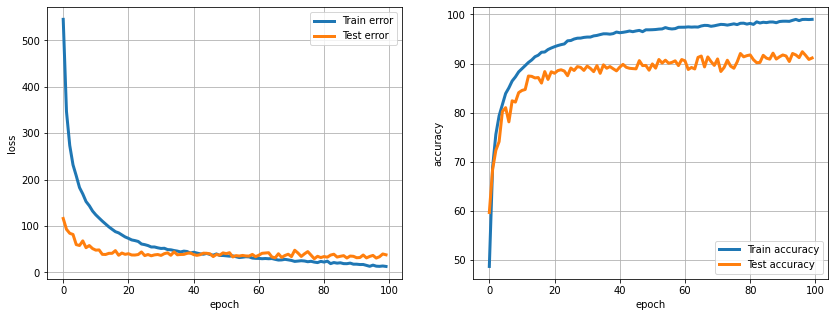

In [15]:
fig = plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(EPOCHS),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(EPOCHS),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()